# Module 04: Linear Regression

In [2]:
# packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

# set seed
seed = 4721

### We'll use the _Bikeshare_ data from ISLP for this activity. The metadata for _Bikeshare_ can be found [here](https://intro-stat-learning.github.io/ISLP/datasets/Bikeshare.html).

In [3]:
# Load the data
Bikeshare = load_data('Bikeshare')

In [4]:
# List the columns and their types
Bikeshare.dtypes

season           int64
mnth          category
day              int64
hr            category
holiday          int64
weekday          int64
workingday       int64
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
bikers           int64
dtype: object

### We will predict the `bikers` column, which is the total of casual and registered bikers. 
Then we can create a matrix of potential independent variables (X) and a dependent variable vector (y).

In [5]:
indep_vars = ['season', 'mnth', 'day', 'hr', 
              'holiday', 'weekday', 'workingday', 
              'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

X = Bikeshare[indep_vars]
y = Bikeshare['bikers']

### Before doing any other analyses, let's create training and test sets.

In [6]:
X_train, X_test, y_train, y_test, Train, Test = train_test_split(X, y, Bikeshare, 
                                                                 random_state = seed, 
                                                                 test_size = 0.25, 
                                                                 shuffle = True)
                             

### We can first summarize the variables in the training data.

In [7]:
Train.describe()

,season,day,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,bikers
count,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000,6483.000000
mean,2.515502,184.328243,0.028382,3.035169,0.679932,0.490066,0.469745,0.643862,0.191836,28.581212,114.752275,143.333488
std,1.102100,104.578153,0.166074,2.013836,0.466538,0.196942,0.175640,0.196966,0.124633,38.973040,109.394295,133.938856
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,95.000000,0.000000,1.000000,0.000000,0.320000,0.318200,0.490000,0.104500,3.000000,26.000000,31.000000
50%,3.000000,185.000000,0.000000,3.000000,1.000000,0.500000,0.484800,0.650000,0.194000,14.000000,89.000000,109.000000
75%,3.000000,274.000000,0.000000,5.000000,1.000000,0.660000,0.621200,0.810000,0.283600,38.000000,167.000000,211.000000
max,4.000000,365.000000,1.000000,6.000000,1.000000,0.960000,1.000000,1.000000,0.850700,272.000000,567.000000,651.000000


### Then we can create plots for each potential independent variable with `bikers` on training data.

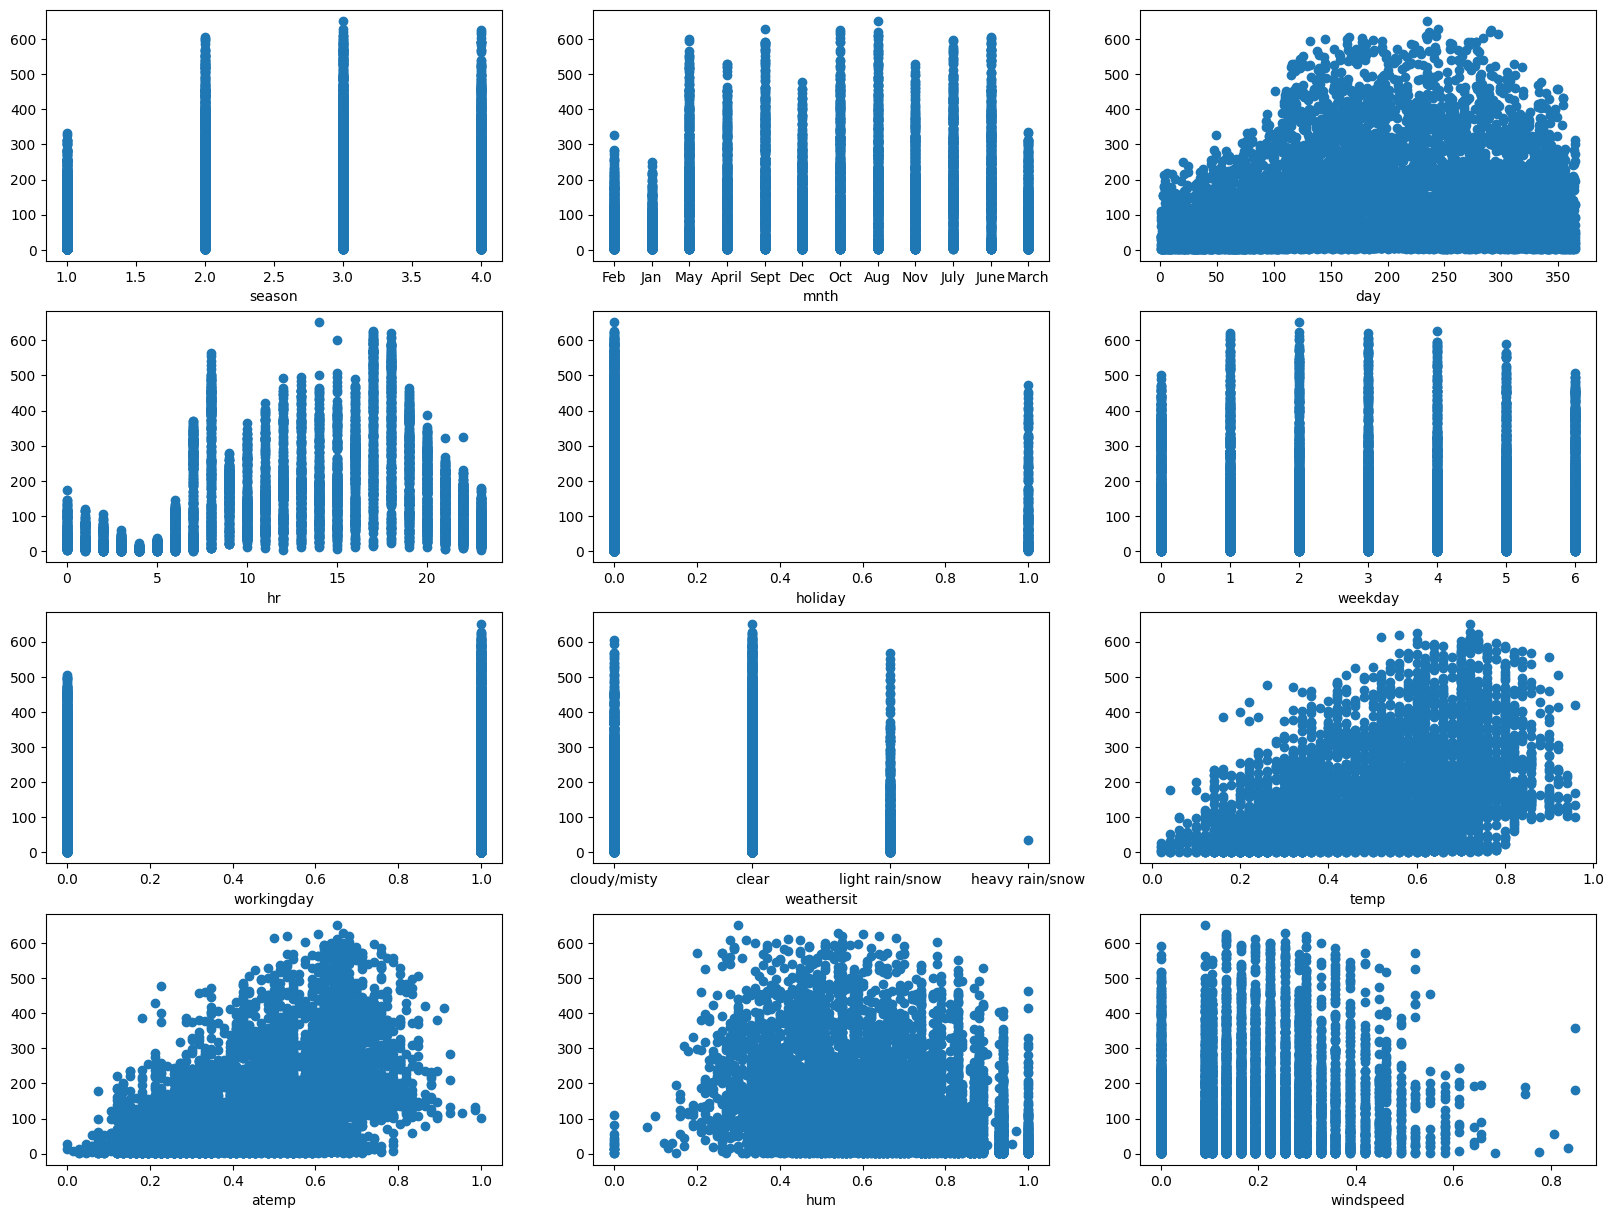

In [8]:
# Initialize the plots before drawing them
nrows = 4
ncols = 3
figsize = (5*nrows, 5*ncols)

fig, axes = subplots(nrows=nrows,
                     ncols=ncols,
                     figsize=figsize)

# Assign a grid location to each index
def range_to_grid(i, nrows, ncols):
    x=[]
    y=[]
    for n in range(nrows*ncols):
        x.append(n // ncols)
        y.append(n % ncols)
        # print(n,x[n],y[n]) # for testing this function
    return x[i],y[i]

# Plot the variables
for j in range(len(X_train.columns)):
    # print(range_to_grid(j,nrows,ncols)[0], range_to_grid(j,nrows,ncols)[1]) # testing
    axes[range_to_grid(j,nrows,ncols)[0],
         range_to_grid(j,nrows,ncols)[1]].plot(X_train.iloc[:,j], y_train, 'o')
    axes[range_to_grid(j,nrows,ncols)[0],
         range_to_grid(j,nrows,ncols)[1]].set_xlabel(X_train.columns[j])

### Explain why you can deduce that there likely are no missing values in this dataset.

Because Train.describe() reports the same count for all variables, and this count equals the total number of observations in the training set. Since the count represents the number of the non-missing values, this means that no missing values.

### The variables that have approximately linear relationship with `bikers` are `temp`, `atemp`, `windspeed`, `workingday`, and `holiday`. 

It appears that time-related variables (`season`, `day`, `hr`, etc.) have non-linear relationships with `bikers`, so we'll hold off on using these variables until the next module.

In [9]:
# correlation of potential linear variables
Train[['bikers', 'temp', 'atemp', 'windspeed', 'workingday', 'holiday']].corr()

,bikers,temp,atemp,windspeed,workingday,holiday
bikers,1.000000,0.454993,0.451417,0.083514,0.018840,-0.022141
temp,0.454993,1.000000,0.991996,-0.001199,0.068249,-0.022510
atemp,0.451417,0.991996,1.000000,-0.041153,0.067167,-0.030258
windspeed,0.083514,-0.001199,-0.041153,1.000000,0.002749,0.007133
workingday,0.018840,0.068249,0.067167,0.002749,1.000000,-0.249106
holiday,-0.022141,-0.022510,-0.030258,0.007133,-0.249106,1.000000


### Explain why `temp` or `atemp` should be used to predict `bikers`, but NOT both.

since temp and atemp are represent the same underlying information, using both make the model coefficient estimates unstable and difficult to interpret.

## First Linear Regression Model

### We can create a column to represent the intercept in our model. 

Some packages do this automatically, but we will leverage the ISLP version, which does not.

In [10]:
X_train['intercept'] = np.ones(X_train.shape[0])
X_test['intercept'] = np.ones(X_test.shape[0])

### Now we'll build a simple linear regression model that uses only `temp` and an intercept to predict `bikers`.

In [11]:
model_1 = sm.OLS(y_train, X_train[['intercept','temp']])
results_1 = model_1.fit()
summarize(results_1)

,coef,std err,t,P>|t|
intercept,-8.3111,3.973,-2.092,0.036
temp,309.4370,7.523,41.133,0.000


### Use this model to predict the number of bikers on a 68F day. 

_Hint_: Use the [metadata](https://intro-stat-learning.github.io/ISLP/datasets/Bikeshare.html) and the fact that 68F = 20C.

temp = 28 / 47 = 0.5957
number of bikers = -8.3111 + 309.4370(temp) = 176.02
so it will be about 176 bikers.

### We will evaluate this model *three ways*: Using R^2, using MSE, and then visually. 

For the last two, we will compare on _Train_ and on _Test_.

In [12]:
# R^2 on training
results_1.rsquared

np.float64(0.20701891421146124)

In [13]:
# Create helper functions for computing the mean squared error

def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def mse(y, y_hat):
    # calculate the residual error for each individual record
    resid = y - y_hat
    # square the residual (hence "squared error")
    sq_resid = resid**2
    # calculate the sum of squared errors
    SSR = sum(sq_resid)
    # divide by the number of records to get the mean squared error
    MSE = SSR / y.shape[0]
    return MSE

In [14]:
predictions_train_1 = predict(X_train[['intercept', 'temp']], results_1)
print('MSE train: ', mse(y_train, predictions_train_1))

predictions_test_1 = predict(X_test[['intercept', 'temp']], results_1)
print('MSE test: ', mse(y_test, predictions_test_1))

MSE train:  14223.58284364993
MSE test:  14355.465212031695


In [15]:
# Define a function to draw a line given coefficients [credit to Hastie & Tibshirani]

def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

KeyError: 0

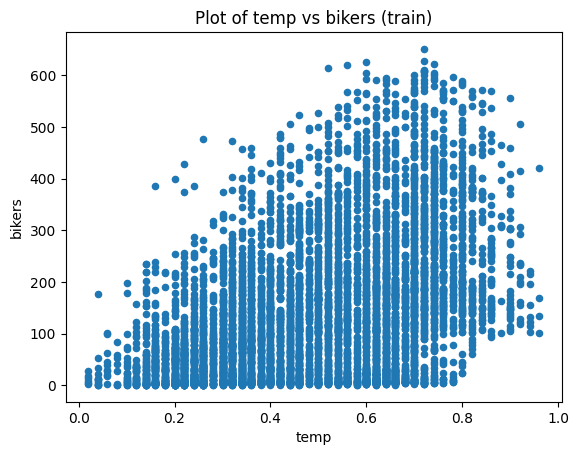

In [16]:
ax = Train.plot.scatter('temp', 'bikers')
ax.set_title("Plot of temp vs bikers (train)")
abline(ax,
       results_1.params[0],
       results_1.params[1],
       'r--',
       linewidth=3)

KeyError: 0

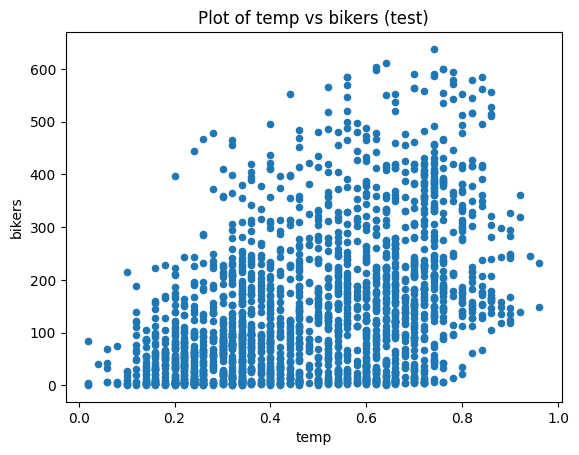

In [ ]:
ax = Test.plot.scatter('temp', 'bikers')
ax.set_title("Plot of temp vs bikers (test)")
abline(ax,
       results_1.params[0],
       results_1.params[1],
       'm--',
       linewidth=3)

### Using the same training set, build a new model that uses both temp and holiday to predict bikers.

In [17]:
model_2 = sm.OLS(y_train, X_train[['intercept', 'temp', 'holiday']])
results_2 = model_2.fit()
summarize(results_2)

,coef,std err,t,P>|t|
intercept,-7.9493,3.987,-1.994,0.046
temp,309.2547,7.525,41.099,0.000
holiday,-9.6015,8.923,-1.076,0.282


### Based on the summary of the new model, does it make sense to include `holiday` as a predictor? Why or why not?

No, it does not make sense to include holiday as a predictor because its coefficient is not statistically significant (p = 0.282), indicating that after accounting for temperature there is no strong evidence that holidays meaningfully affect the number of bikers.

### Compute the R^2 coefficient for the new model.

In [18]:
results_2.rsquared

np.float64(0.2071605749999137)

### Compute the MSE on the training and test sets for the new model. 

In [20]:
predictions_train_2 = predict(X_train[['intercept', 'temp', 'holiday']], results_2)

predictions_test_2 = predict(X_test[['intercept', 'temp', 'holiday']], results_2)
print('MSE train:', mse(y_train, predictions_train_2))
print('MSE test :', mse(y_test, predictions_test_2))


MSE train: 14221.041895326749
MSE test : 14349.567846691396


### Based on the MSE calculations, is this model better or worse than the model containing only `temp`? Why or why not?

The differences are tiny relative to the magnitude of the MSE, although the second model has a slightly lower MSE on both sets, and since holiday is not statistically significant, the simpler model using only temp is better.

### Now build a model using `windspeed` instead of `holiday` as a predictor. 

In [21]:
model_3 = sm.OLS(y_train, X_train[['intercept', 'temp', 'windspeed']])
results_3 = model_3.fit()
summarize(results_3)

,coef,std err,t,P>|t|
intercept,-25.6745,4.563,-5.626,0.0
temp,309.5055,7.490,41.324,0.0
windspeed,90.3362,11.835,7.633,0.0


### Compute the R^2 for this model.

In [22]:
results_3.rsquared

np.float64(0.21408496247446074)

### Compute the MSE for this model on train and test.

In [23]:
predictions_train_3 = predict(X_train[['intercept', 'temp', 'windspeed']], results_3)

predictions_test_3 = predict(X_test[['intercept', 'temp', 'windspeed']], results_3)
print('MSE train:', mse(y_train, predictions_train_3))
print('MSE test :', mse(y_test, predictions_test_3))


MSE train: 14096.84019537345
MSE test : 14182.224118806698


### Out of the three models, which would you choose? Why?

I would choose Model 3 since it has the lowest MSE on both the training and test sets, meaning it has better predictive performance, and it improves the model without adding an insignificant predictor.